## 1. Set Kaggle API information and dataset local directories

In [1]:
# Set Kaggle API - Username / Key
import os
os.environ['KAGGLE_USERNAME'] = "franconicolsmerenda"
os.environ['KAGGLE_KEY'] = "edcd91fb1521ad3ee181a8b093795eab"
os.environ['DATASET_FOLDER'] = "/home/millenium-falcon/SoftwareProjects/ai-art-casa/.datasets" #change this directory to the one where the data is
os.environ['ART_STYLE'] = "realism"

# DATASET Folders
os.environ['TRAIN_DATASET_ART_STYLE'] = f"{os.environ['DATASET_FOLDER']}/Real_AI_SD_LD_Dataset/train"
os.environ['TEST_DATASET_ART_STYLE'] = f"{os.environ['DATASET_FOLDER']}/Real_AI_SD_LD_Dataset/test"

# Data to be consumed by the model!
os.environ['TOP_DIR']=f"{os.environ['DATASET_FOLDER']}/{os.environ['ART_STYLE']}"
os.environ['TRAIN_ART_STYLE_DATA'] = f"{os.environ['DATASET_FOLDER']}/{os.environ['ART_STYLE']}/train"
os.environ['VALID_ART_STYLE_DATA'] = f"{os.environ['DATASET_FOLDER']}/{os.environ['ART_STYLE']}/valid"

## 2. Download dataset if it is not stored locally

In [2]:
# Download Datasets if Needed
import os

# Define the folder path
folder_path = f"{os.environ['DATASET_FOLDER']}"

# Check if the folder exists
if not os.path.exists(f"{folder_path}/Real_AI_SD_LD_Dataset"):
    # Install kaggle package
    !pip install -q kaggle
    # Download the dataset from Kaggle
    !kaggle datasets download -d ravidussilva/real-ai-art -p $folder_path --unzip
else:
    print("Folder already exists.")

Folder already exists.


## 3. Copy and divide images into directories separating them by the requested Art Style

In [3]:
# Set Art Style Dataset

# 1. Make clean data
!rm -rf $TRAIN_ART_STYLE_DATA
!rm -rf $VALID_ART_STYLE_DATA

# 2. Create folders of the current art style training/validation data
!mkdir -p $TRAIN_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!mkdir -p $TRAIN_ART_STYLE_DATA/$ART_STYLE

!mkdir -p $VALID_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!mkdir -p $VALID_ART_STYLE_DATA/$ART_STYLE

# 3. Load with data from DATASET
!cp -r $TRAIN_DATASET_ART_STYLE/AI_LD_$ART_STYLE/*.jpg $TRAIN_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!cp -r $TRAIN_DATASET_ART_STYLE/AI_SD_$ART_STYLE/*.jpg $TRAIN_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!cp -r $TRAIN_DATASET_ART_STYLE/$ART_STYLE/*.jpg $TRAIN_ART_STYLE_DATA/$ART_STYLE

!cp -r $TEST_DATASET_ART_STYLE/AI_LD_$ART_STYLE/*.jpg $VALID_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!cp -r $TEST_DATASET_ART_STYLE/AI_SD_$ART_STYLE/*.jpg $VALID_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!cp -r $TEST_DATASET_ART_STYLE/$ART_STYLE/*.jpg $VALID_ART_STYLE_DATA/$ART_STYLE

## 4. Import the needed dependencies for the model and data visualization

In [4]:
#Import Dependencies
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

2024-07-18 13:04:37.252515: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 13:04:37.741309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 5. Set dataset parameters and details

In [5]:
# Define paths to training and validation data
train_data_dir = os.environ['TRAIN_ART_STYLE_DATA']
valid_data_dir = os.environ['VALID_ART_STYLE_DATA']

# Define constants
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64
NUM_EPOCHS = 30

## 6. Define the directory path for training dataset

In [6]:
#Main directory where datasets are stored
top_dir = os.environ['TOP_DIR']

# Define the training paths
train_dir = os.path.join(top_dir, 'train')

# List all directories in the train directory
all_directories = os.listdir(train_dir)

# Initialize lists to store directories for human-drawn and AI-generated images
train_human = []
train_ai = []

# Loop through all directories
for directory in all_directories:
    # Check if the directory represents human-drawn images
    if not directory.startswith('AI_'):
        train_human.append(os.path.join(train_dir, directory))
    # Check if the directory represents AI-generated images
    else:
        train_ai.append(os.path.join(train_dir, directory))

# Print the lists of directories
print("Train directories containing human-drawn images:")
for i, directory in enumerate(train_human):
    print(f"{i}. {directory}")

print("\nTrain directories containing AI-generated images:")
for i, directory in enumerate(train_ai):
    print(f"{i}. {directory}")

Train directories containing human-drawn images:
0. /home/millenium-falcon/SoftwareProjects/ai-art-casa/notebooks/.datasets/surrealism/train/surrealism

Train directories containing AI-generated images:
0. /home/millenium-falcon/SoftwareProjects/ai-art-casa/notebooks/.datasets/surrealism/train/AI_GENERATED_surrealism


## 7. Define the directory path for validation dataset

In [7]:
# Define the test paths
test_dir = os.path.join(top_dir, 'valid')

# List all directories in the test directory
all_directories = os.listdir(test_dir)

# Initialize lists to store directories for human-drawn and AI-generated images
test_human = []
test_ai = []

# Loop through all directories
for directory in all_directories:
    # Check if the directory represents human-drawn images
    if not directory.startswith('AI_'):
        test_human.append(os.path.join(test_dir, directory))
    # Check if the directory represents AI-generated images
    else:
        test_ai.append(os.path.join(test_dir, directory))

# Print the lists of directories
print("Test directories containing human-drawn images:")
for i, directory in enumerate(test_human):
    print(f"{i}. {directory}")

print("\nTest directories containing AI-generated images:")
for i, directory in enumerate(test_ai):
    print(f"{i}. {directory}")

Test directories containing human-drawn images:
0. /home/millenium-falcon/SoftwareProjects/ai-art-casa/notebooks/.datasets/surrealism/valid/surrealism

Test directories containing AI-generated images:
0. /home/millenium-falcon/SoftwareProjects/ai-art-casa/notebooks/.datasets/surrealism/valid/AI_GENERATED_surrealism


## 8. Data preprocessing- Labeling training data. 

In [8]:
# Initialize lists to store file paths and labels
filepaths = []
labels = []

# Initialize an empty DataFrame for train_data with the columns filepath and label
train_data = pd.DataFrame(columns=['filepath', 'label'])

# Label files under train_human as "human"
for directory in train_human:
    for file in os.listdir(directory):
        #creating value to store in filepath column
        filepath = os.path.join(directory, file)
        #append value into the column filepath
        filepaths.append(filepath)
        #adding classification 'human' to value
        labels.append("human")

# Label files under train_ai as "AI"
for directory in train_ai:
    for file in os.listdir(directory):
        #creating value to store in filepath column
        filepath = os.path.join(directory, file)
        #append value into the column filepath
        filepaths.append(filepath)
        #adding classification 'AI' to value
        labels.append("AI")

# Create a DataFrame with file paths and labels
data = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Concatenate data with train_data
train_data = pd.concat([train_data, data], ignore_index=True)

## 9. Display the amount of images for training dataset

In [10]:
# Count the number of files under each label
file_counts = train_data['label'].value_counts()

# Print the counts
print("Number of files under each label:")
print(file_counts)

Number of files under each label:
label
AI       10748
human     5000
Name: count, dtype: int64


## 10. Data preprocessing- Labeling validation data. 

In [12]:
# Initialize lists to store file paths and labels
filepaths = []
labels = []

# Initialize an empty DataFrame for test_data
test_data = pd.DataFrame(columns=['filepath', 'label'])

# Label files under test_human as "human"
for directory in test_human:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("human")

# Label files under test_ai as "AI"
for directory in test_ai:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("AI")

# Create a DataFrame with file paths and labels
data = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Concatenate data with test_data
test_data = pd.concat([test_data, data], ignore_index=True)

## 11. Display the amount of images for validation dataset

In [13]:
# Display the first few rows of the test_data DataFrame
print(test_data.head())

# Count the number of files under each label
file_counts = test_data['label'].value_counts()

# Print the counts
print("\nNumber of files under each label:")
print(file_counts)

                                            filepath  label
0  /home/millenium-falcon/SoftwareProjects/ai-art...  human
1  /home/millenium-falcon/SoftwareProjects/ai-art...  human
2  /home/millenium-falcon/SoftwareProjects/ai-art...  human
3  /home/millenium-falcon/SoftwareProjects/ai-art...  human
4  /home/millenium-falcon/SoftwareProjects/ai-art...  human

Number of files under each label:
label
AI       2000
human    1000
Name: count, dtype: int64


## 12. Data preprocessing- Adding data augmentation and creating training dataset. 

In [14]:
#Created training set with data augmentation
training_generator = ImageDataGenerator(rescale=1./255,   # to normalize pixel value
                                        rotation_range=7, # it will apply rotations to the image
                                        horizontal_flip=True, # it will flip image horizontally
                                       )
train_dataset = training_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',  
    shuffle=True
)

Found 15748 validated image filenames belonging to 2 classes.


In [15]:
train_dataset.class_indices

{'AI': 0, 'human': 1}

## 13. Data preprocessing- Adding data augmentation and creating validation dataset. 

In [16]:
#Created validation set
val_generator = ImageDataGenerator(rescale=1./255,            # Normalize the image pixel values to the range [0, 1] by scaling by 1/255
    validation_split=0.2,      # Reserve 20% of the data for validation
    rotation_range=20,         # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,     # Randomly translate images horizontally by up to 20% of the width
    height_shift_range=0.2,    # Randomly translate images vertically by up to 20% of the height
    shear_range=0.2,           # Randomly apply shear transformations by up to 20%
    zoom_range=0.2,            # Randomly zoom into images by up to 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest' )       # Fill in newly created pixels after transformations with the nearest pixel value
val_dataset = val_generator.flow_from_dataframe(  dataframe=test_data,
                                                    x_col='filepath',  # Column containing file paths
                                                    y_col='label',     # Column containing labels
                                                    target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size = 1,    # 1 image at a time to evaluate the NN
                                                    class_mode = 'binary',
                                                    shuffle = False)   # to associate the prediction with expected output


Found 3000 validated image filenames belonging to 2 classes.


{'AI': 0, 'human': 1}

## 14. Defining VGG19 model with transfer learning and show its summary.

In [17]:
#Created network using VGG19 and transfer learning from 'ImageNet'
network= VGG19(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

for layer in network.layers:
    layer.trainable=False
network.summary()

# Added layers to the base model created by VGG19
flatten_layer = Flatten()
dense_layer_1 = Dense(256, activation='relu') 
dropout_1= Dropout(0.5)
predictions = Dense(units = 1, activation='sigmoid')

model = Sequential([
   network,
   flatten_layer,
   dense_layer_1,
    dropout_1,
   predictions
],)

2024-07-18 13:05:08.665043: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-18 13:05:08.706092: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-18 13:05:08.706293: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

## 15. Compile the model

In [18]:
# Compile the model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
#Add EarlyStopping with a patience of 5 to avoid overfitting. 
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

## 16. Train the model :)

In [19]:
#TRAINING MODEL
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=val_dataset, callbacks=[es])

Epoch 1/30


/home/millenium-falcon/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1721318717.881382  497092 service.cc:145] XLA service 0x7ca024010360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721318717.881405  497092 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-07-18 13:05:17.906699: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-18 13:05:18.084377: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024

  2/247 ━━━━━━━━━━━━━━━━━━━━ 24s 99ms/step - accuracy: 0.7305 - loss: 0.7011 

I0000 00:00:1721318725.879525  497092 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


247/247 ━━━━━━━━━━━━━━━━━━━━ 118s 433ms/step - accuracy: 0.8275 - loss: 0.8345 - val_accuracy: 0.9393 - val_loss: 0.1529
Epoch 2/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 109s 431ms/step - accuracy: 0.9250 - loss: 0.1906 - val_accuracy: 0.9377 - val_loss: 0.1560
Epoch 3/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 108s 427ms/step - accuracy: 0.9280 - loss: 0.1858 - val_accuracy: 0.9393 - val_loss: 0.1565
Epoch 4/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 108s 428ms/step - accuracy: 0.9327 - loss: 0.1706 - val_accuracy: 0.9270 - val_loss: 0.1835
Epoch 5/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 108s 427ms/step - accuracy: 0.9398 - loss: 0.1569 - val_accuracy: 0.9453 - val_loss: 0.1371
Epoch 6/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 108s 428ms/step - accuracy: 0.9411 - loss: 0.1521 - val_accuracy: 0.9430 - val_loss: 0.1471
Epoch 7/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 109s 432ms/step - accuracy: 0.9412 - loss: 0.1486 - val_accuracy: 0.9483 - val_loss: 0.1414
Epoch 8/30
247/247 ━━━━━━━━━━━━━━━━━━━━ 109s 429ms/step - accuracy: 0.9471 - loss: 0.14

## 17. Plotting the accuracy and loss functions of the epochs

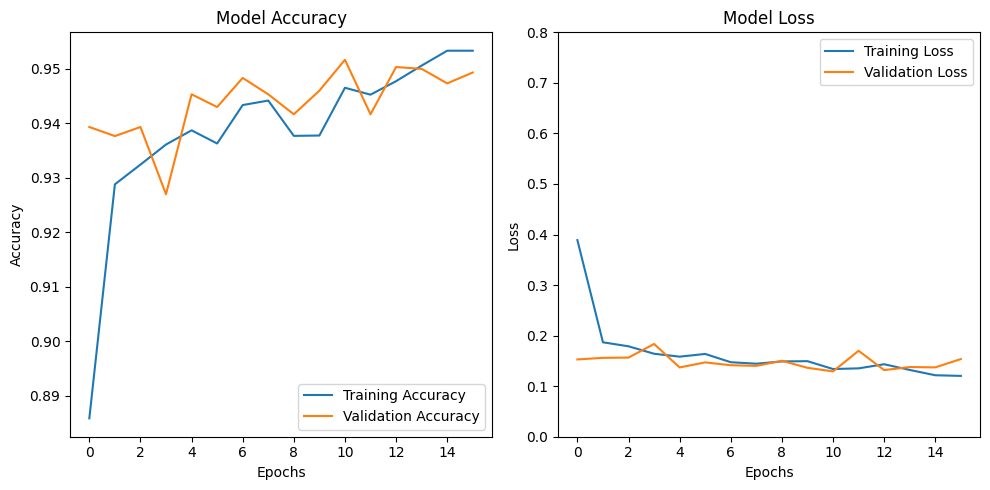

In [20]:
# Accuracy vs Loss

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.8)  # Adjust the upper limit of the y-axis
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 18. Evaluate the trained model  

In [ ]:
test_loss, test_acc = model.evaluate(val_dataset)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

## 19. Make predictions with the trained model

In [ ]:
# Get the true labels
true_labels = val_dataset.classes

# Make predictions
predictions = model.predict(val_dataset)
predicted_labels = np.round(predictions).flatten()  # For binary classification

## 20. Generate the confusion matrix to validate results and plot the information

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'human'], yticklabels=['AI', 'human'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()